# TM10007 Assignment 3
Linde Zegwaard (4779673), Emmelieve den Breejen (4996690), Fleur Lycklama à Nijeholt (4834011)


# Import modules

In [ ]:
# Import modules
import os
import pandas as pd
import sklearn as skl
from sklearn.feature_selection import SelectKBest
import matplotlib.pyplot as plt
import torch
import pandas
import numpy as np
import seaborn
import os
import PIL
from scipy import stats
%pip install mlxtend --upgrade
from sklearn.inspection import DecisionBoundaryDisplay
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Clone TM10007 github
!git clone https://github.com/jveenland/tm10007_ml.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'tm10007_ml' already exists and is not an empty directory.


# Data split

In [ ]:
# Load data
data = pd.read_csv('/content/tm10007_ml/worcgist/GIST_radiomicFeatures.csv', index_col=0)
data = data.set_index(['label']) # set the label as index
features = data.columns.values.tolist() # make list with all feature names

print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)}')
print(data.index.value_counts().to_dict())
print()

# Split in test and train set, stratified by label
data_train, data_test, labels_train, labels_test = skl.model_selection.train_test_split(data, data.index, test_size=0.3, random_state=10007, stratify=data.index)
labels_train = pd.Series(labels_train)
labels_test = pd.Series(labels_test)

print(f'The number of test samples: {len(data_test.index)}')
print(data_test.index.value_counts().to_dict())
print()

print(f'The number of train samples: {len(data_train.index)}')
print(data_train.index.value_counts().to_dict())

# Create splits for cross validation
sss5 = skl.model_selection.StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=10007)
sss10 = skl.model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=10007)

The number of samples: 246
The number of features: 493
{'GIST': 125, 'non-GIST': 121}

The number of test samples: 74
{'GIST': 38, 'non-GIST': 36}

The number of train samples: 172
{'GIST': 87, 'non-GIST': 85}


# Data exploration & preprocessing

## Distribution

In [ ]:
# test for normal distribution
n_normal = 0
n_notnormal = 0

for column in data_train:
  _, p = stats.shapiro(data_train[column])
  if p > 0.05:
    n_normal += 1
  else:
    n_notnormal += 1

print(f'The number of normally distributed columns: {n_normal}')
print(f'The number of not normally distributed columns: {n_notnormal}')

The number of normally distributed columns: 74
The number of not normally distributed columns: 419


/usr/local/lib/python3.9/dist-packages/scipy/stats/_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


## Outliers

In [ ]:
# test for outliers in each column
Q1 = data_train.quantile(0.25)
Q3 = data_train.quantile(0.75)
IQR = Q3 - Q1

outliers = (data_train < (Q1 - 1.5 * IQR))|(data_train > (Q3 + 1.5 * IQR))
outliers = outliers.sum()


n_outliers = (outliers != 0).sum()

print(f'The number of columns with outliers: {n_outliers}')

The number of columns with outliers: 410


## Scaling

In [ ]:
# Robust scaling
scaler = skl.preprocessing.RobustScaler()
scaler.fit(data_train)
data_train_robust = scaler.transform(data_train)

# MinMax scaling
scaler = skl.preprocessing.MinMaxScaler()
scaler.fit(data_train)
data_train_minmax = scaler.transform(data_train)

## PCA to 2 components

[Text(0.5, 0, 'Component 1'),
 Text(0, 0.5, 'Component 2'),
 Text(0.5, 1.0, 'PCA with 2 components after Robust scaling')]

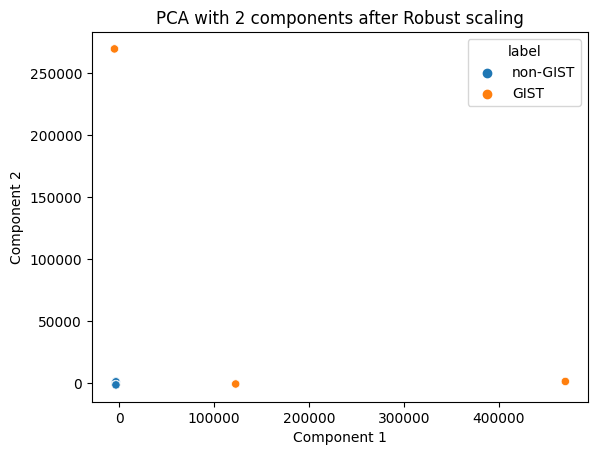

In [ ]:
# PCA after robust scaling
pca = skl.decomposition.PCA(n_components=2)
pca.fit(data_train_robust)

data_train_pca = pca.transform(data_train_robust)
data_train_pca = pd.DataFrame(data_train_pca)

ax = seaborn.scatterplot(data=data_train_pca, x = 0, y = 1, hue = labels_train)
ax.set(xlabel='Component 1', ylabel='Component 2', title = 'PCA with 2 components after Robust scaling')

[Text(0.5, 0, 'Component 1'),
 Text(0, 0.5, 'Component 2'),
 Text(0.5, 1.0, 'PCA with 2 components after MinMax scaling')]

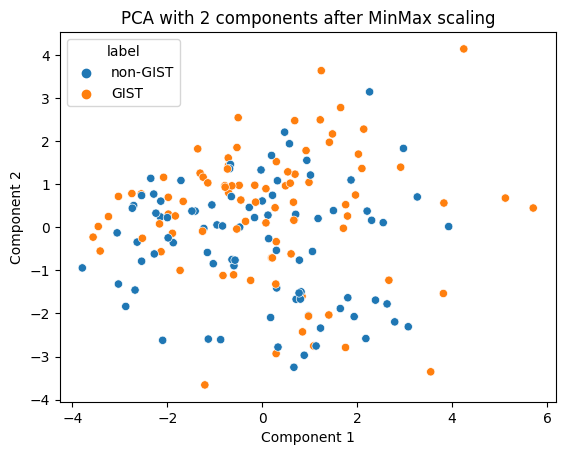

In [ ]:
# PCA after minmax scaling
pca = skl.decomposition.PCA(n_components=2)
pca.fit(data_train_minmax)

data_train_pca = pca.transform(data_train_minmax)
data_train_pca = pd.DataFrame(data_train_pca)

ax = seaborn.scatterplot(data=data_train_pca, x = 0, y = 1, hue = labels_train)
ax.set(xlabel='Component 1', ylabel='Component 2', title = 'PCA with 2 components after MinMax scaling')

# Feature extraction through PCA

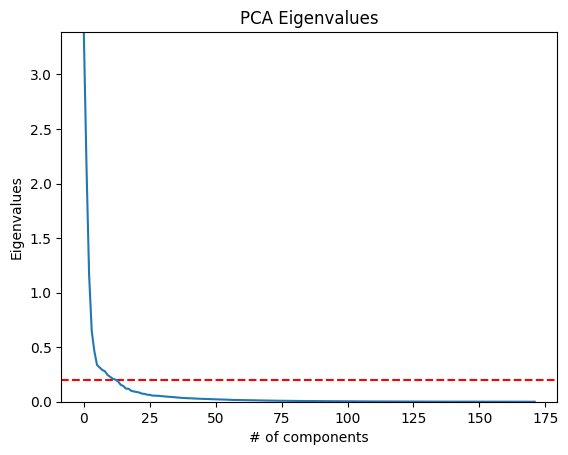

In [ ]:
# Scree plot to determine the number of components
pca = skl.decomposition.PCA(n_components=172, random_state=10007)
pca.fit(data_train_minmax)
eigenvalues = pca.explained_variance_

plt.ylabel('Eigenvalues')
plt.xlabel('# of components')
plt.title('PCA Eigenvalues')
plt.ylim(0, max(pca.explained_variance_))
plt.style.context('seaborn-whitegrid')
plt.axhline(y=0.2, color='r', linestyle='--')
plt.plot(pca.explained_variance_)
plt.show()

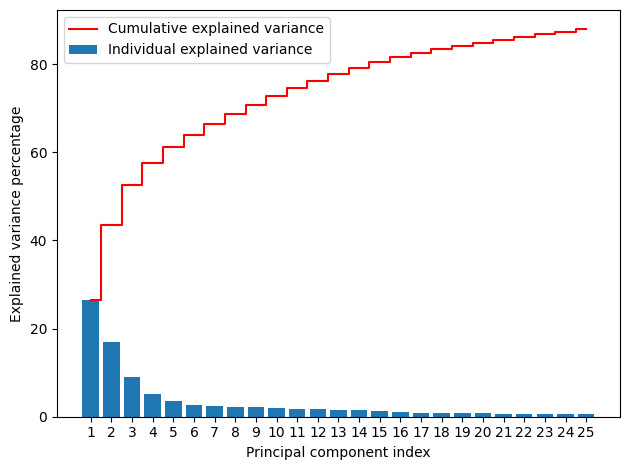

In [ ]:
# Variance plot to choose the optimal number of components

pca = skl.decomposition.PCA(n_components=25, random_state=10007)
pca.fit(data_train_minmax)

exp_var = pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

plt.bar(range(1, 26), exp_var, align='center',
        label='Individual explained variance')

plt.step(range(1, 26), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.xticks(ticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])
plt.legend(loc='best')
plt.tight_layout()

# plt.savefig("Barplot.png")

In [ ]:
# Perform principal component analysis (PCA)
pca = skl.decomposition.PCA(n_components=15, random_state=10007)
pca.fit(data_train_minmax)

data_train_pca = pca.transform(data_train_minmax)

# Feature selection trough Greedy network

## SV

In [ ]:
# This code takes long to run
# Feature selection with Support Vector classifier

# Performance curve to determine the optimal number of features
#sfs = SequentialFeatureSelector(estimator=skl.svm.SVC(), k_features=15, scoring='roc_auc', cv = sss5)
#sfs.fit(data_train_robust, labels_train)

#plot_sfs(sfs.get_metric_dict(), kind='std_dev')
#plt.title('Sequential Forward Selection (w. StdDev)')
#plt.grid()
#plt.show()

In [ ]:
# Select 9 features with Support Vector classifier
sfs = SequentialFeatureSelector(estimator=skl.svm.SVC(), k_features=9, scoring='roc_auc', cv = sss5)
data_train_features_sv = sfs.fit_transform(data_train_robust, labels_train)
data_train_features_sv = pd.DataFrame(data_train_features_sv)
data_train_features_sv = data_train_features_sv.to_numpy()
features_sv = sfs.k_feature_names_
features_sv = [features[eval(i)] for i in features_sv]
print(f'9 features for SV classifier: {features_sv}')

9 features for SV classifier: ['PREDICT_original_hf_median', 'PREDICT_original_logf_median_sigma1', 'PREDICT_original_logf_peak_position_sigma10', 'PREDICT_original_tf_GLCMMS_correlationd3.0A2.36std', 'PREDICT_original_tf_Gabor_peak_F0.05_A0.0', 'PREDICT_original_tf_Gabor_mean_F0.2_A0.0', 'PREDICT_original_tf_Gabor_median_F0.2_A0.0', 'PREDICT_original_tf_Gabor_mean_F0.2_A0.79', 'PREDICT_original_vf_Frangi_full_skewness_SR(1.0, 10.0)_SS2.0']


## RF

In [ ]:
# This code takes long to run
# Feature selection with Random Forest classifier

# Reduce dimensionality
data_train_kbest = SelectKBest(k=30).fit_transform(data_train_robust, labels_train)

# Performance curve to determine optimal number of features
#sfs = SequentialFeatureSelector(estimator=skl.ensemble.RandomForestClassifier(random_state = 10007), k_features = 10, scoring='roc_auc', cv = sss5)
#sfs.fit(data_train_kbest, labels_train)

#plot_sfs(sfs.get_metric_dict(), kind='std_dev')
#plt.title('Sequential Forward Selection (w. StdDev)')
#plt.grid()
#plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 77  83  84  90  97 103 110 467 470 474 475 480 487 488] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [ ]:
# Select 5 features with Random Forest classifier
sfs = SequentialFeatureSelector(estimator=skl.ensemble.RandomForestClassifier(random_state = 10007), k_features=5, scoring='roc_auc', cv = sss5)
data_train_features_rf = sfs.fit_transform(data_train_kbest, labels_train)
data_train_features_rf = pd.DataFrame(data_train_features_rf)
data_train_features_rf = data_train_features_rf.to_numpy()
features_rf = sfs.k_feature_names_
features_rf = [features[eval(i)] for i in features_rf]
print(f'5 features for RF classifier: {features_rf}')

5 features for RF classifier: ['PREDICT_original_sf_solidity_std_2.5D', 'PREDICT_original_sf_area_min_2.5D', 'PREDICT_original_of_theta_y', 'PREDICT_original_of_theta_z', 'PREDICT_original_hf_median']


## kNN

In [ ]:
# This code takes long to run
# Feature selection with kNN classifier

# Performance curve to determine optimal number of features
#sfs = SequentialFeatureSelector(estimator=skl.neighbors.KNeighborsClassifier(n_neighbors=5), k_features=10, scoring='roc_auc', cv = sss5)
#sfs.fit(data_train_robust, labels_train)

#plot_sfs(sfs.get_metric_dict(), kind='std_dev')
#plt.title('Sequential Forward Selection (w. StdDev)')
#plt.grid()
#plt.show()

In [ ]:
# Select 5 features with kNN classifier
sfs = SequentialFeatureSelector(estimator=skl.neighbors.KNeighborsClassifier(n_neighbors=5), k_features=5, scoring='roc_auc', cv = sss5)
data_train_features_knn = sfs.fit_transform(data_train_robust, labels_train)
data_train_features_knn = pd.DataFrame(data_train_features_knn)
data_train_features_knn = data_train_features_knn.to_numpy()
features_knn = sfs.k_feature_names_
features_knn = [features[eval(i)] for i in features_knn]
print(f'5 features for kNN classifier: {features_knn}')

5 features for kNN classifier: ['PREDICT_original_tf_LBP_median_R15_P36', 'PREDICT_original_tf_GLCMMS_dissimilarityd3.0A0.79mean', 'PREDICT_original_tf_Gabor_kurtosis_F0.05_A1.57', 'PREDICT_original_tf_Gabor_median_F0.2_A0.0', 'PREDICT_original_tf_Gabor_energy_F0.2_A2.36']


# Support Vector classifier

## SV classification with components

### Kernel type

Text(0, 0.5, 'Accuracy')

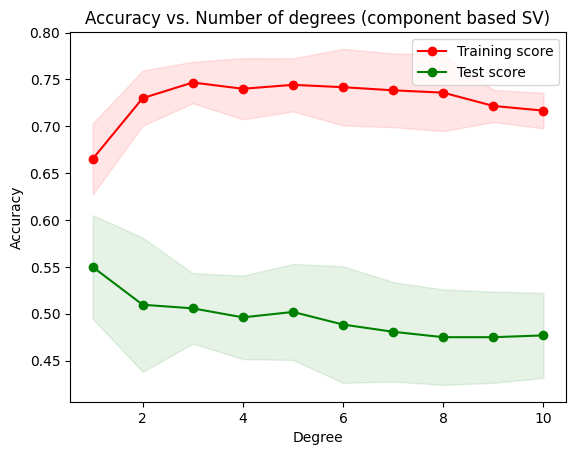

In [ ]:
# degrees of polynomial kernel

degrees = list(range(1,11))
all_train = []
all_test = []

for train_index, test_index in sss10.split(data_train_pca, labels_train):
    train_scores = []
    test_scores = []
    
    split_X_train = data_train_pca[train_index]
    split_y_train = labels_train[train_index]
    split_X_test = data_train_pca[test_index]
    split_y_test = labels_train[test_index]

    for degree in degrees:
        clf = skl.svm.SVC(kernel = 'poly', degree=degree)
        clf.fit(split_X_train, split_y_train)

        # Test the classifier on the training data and plot
        score_train = clf.score(split_X_train, split_y_train)
        score_test = clf.score(split_X_test, split_y_test)

        train_scores.append(score_train)
        test_scores.append(score_test)
        
    all_train.append(train_scores)
    all_test.append(test_scores)

# Create numpy array of scores and calculate the mean and std
all_train = np.array(all_train)
all_test = np.array(all_test)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)

# Plot the mean scores and the std as shading
fig = plt.figure()
ax = fig.add_subplot(111)
ax.fill_between(degrees, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(degrees, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
ax.plot(degrees, train_scores_mean, 'o-', color="r", label="Training score")
ax.plot(degrees, test_scores_mean, 'o-', color="g", label="Test score")
plt.legend()
plt.title('Accuracy vs. Number of degrees (component based SV)')
plt.xlabel('Degree')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

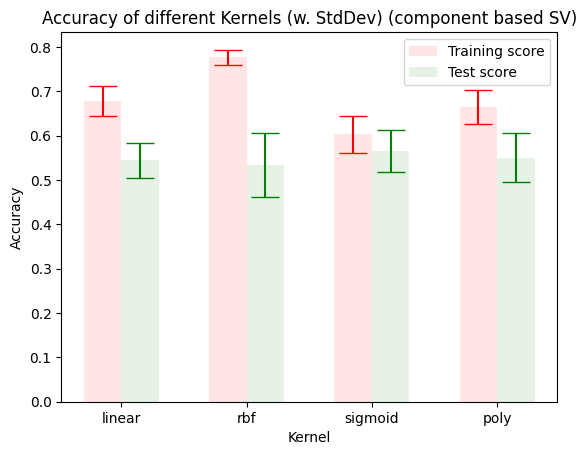

In [ ]:
# different kernels

kernels = ['linear', 'rbf', 'sigmoid', 'poly']
all_train = []
all_test = []

for train_index, test_index in sss10.split(data_train_pca, labels_train):
    train_scores = []
    test_scores = []
    
    split_X_train = data_train_pca[train_index]
    split_y_train = labels_train[train_index]
    split_X_test = data_train_pca[test_index]
    split_y_test = labels_train[test_index]

    for kernel in kernels:
        clf = skl.svm.SVC(kernel=kernel, degree=1)
        clf.fit(split_X_train, split_y_train)

        # Test the classifier on the training data and plot
        score_train = clf.score(split_X_train, split_y_train)
        score_test = clf.score(split_X_test, split_y_test)

        train_scores.append(score_train)
        test_scores.append(score_test)
        
    all_train.append(train_scores)
    all_test.append(test_scores)

# Create numpy array of scores and calculate the mean and std
all_train = np.array(all_train)
all_test = np.array(all_test)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)

# Plot the mean scores and the std as shading
br1 = np.arange(len(kernels))
br2 = [x + 0.3 for x in br1]

fig = plt.figure()
plt.bar(br1, train_scores_mean, color = 'r', alpha = 0.1, width = 0.3, label="Training score", yerr=train_scores_std, ecolor='r', capsize=10)
plt.bar(br2, test_scores_mean, color = 'g', alpha = 0.1, width = 0.3, label="Test score", yerr=test_scores_std, ecolor='g', capsize=10)
plt.xticks([r + 0.15 for r in range(len(kernels))], kernels)
plt.legend()
plt.title('Accuracy of different Kernels (w. StdDev) (component based SV)')
plt.xlabel('Kernel')
plt.ylabel('Accuracy')

### ROC curve

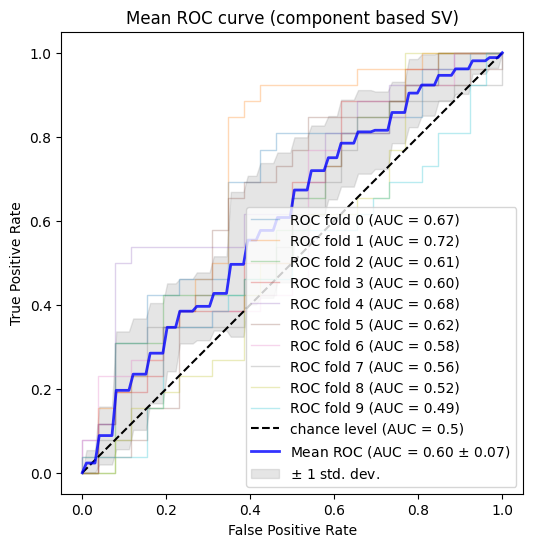

Mean accuracy: 0.57 (std: 0.05)


In [ ]:
# ROC curve (sigmoid kernel)
svc = skl.svm.SVC(kernel = 'sigmoid', random_state = 10007)

tprs = []
aucs = []
accuracy = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(sss10.split(data_train_pca, labels_train)):
    svc.fit(data_train_pca[train], labels_train[train])
    viz = skl.metrics.RocCurveDisplay.from_estimator(
        svc,
        data_train_pca[test],
        labels_train[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    y_pred = svc.predict(data_train_pca[test])
    accuracy.append(skl.metrics.accuracy_score(labels_train[test], y_pred))

ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = skl.metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Mean ROC curve (component based SV)",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()

mean_accuracy = np.mean(accuracy)
std_accuracy = np.std(accuracy)
print(f'Mean accuracy: {np.round(mean_accuracy, decimals=2)} (std: {np.round(std_accuracy, decimals=2)})')

### Learning curve

Text(0.5, 1.0, 'Learning curve (component based SV)')

<Figure size 640x480 with 0 Axes>

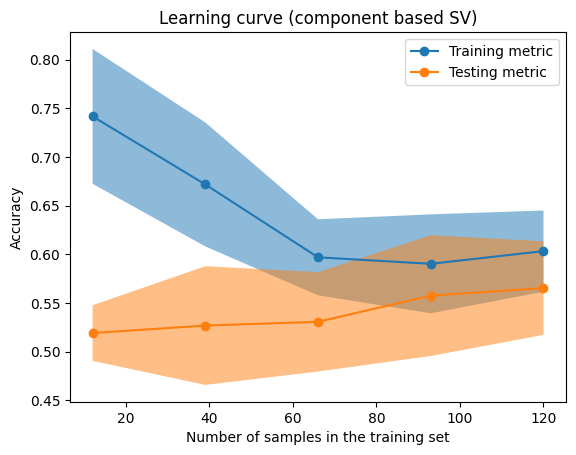

In [ ]:
# learning curve
clf = svc = skl.svm.SVC(kernel = 'sigmoid')

fig = plt.figure()

common_params = {
    "X": data_train_pca,
    "y": labels_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": sss10,
    "score_type": "both",
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

skl.model_selection.LearningCurveDisplay.from_estimator(clf, **common_params)
plt.title('Learning curve (component based SV)')

## SV classification with features

### Kernel type

Text(0, 0.5, 'Accuracy')

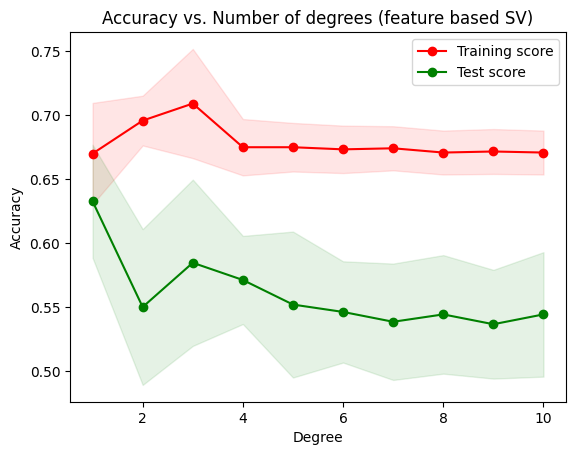

In [ ]:
# degrees of polynomial kernel

degrees = list(range(1,11))
all_train = []
all_test = []

for train_index, test_index in sss10.split(data_train_features_sv, labels_train):
    train_scores = []
    test_scores = []
    
    split_X_train = data_train_features_sv[train_index]
    split_y_train = labels_train[train_index]
    split_X_test = data_train_features_sv[test_index]
    split_y_test = labels_train[test_index]

    for degree in degrees:
        clf = skl.svm.SVC(kernel = 'poly', degree=degree)
        clf.fit(split_X_train, split_y_train)

        # Test the classifier on the training data and plot
        score_train = clf.score(split_X_train, split_y_train)
        score_test = clf.score(split_X_test, split_y_test)

        train_scores.append(score_train)
        test_scores.append(score_test)
        
    all_train.append(train_scores)
    all_test.append(test_scores)

# Create numpy array of scores and calculate the mean and std
all_train = np.array(all_train)
all_test = np.array(all_test)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)

# Plot the mean scores and the std as shading
fig = plt.figure()
ax = fig.add_subplot(111)
ax.fill_between(degrees, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.1,
                color="r")
ax.fill_between(degrees, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.1,
                color="g")
ax.plot(degrees, train_scores_mean, 'o-', color="r", label="Training score")
ax.plot(degrees, test_scores_mean, 'o-', color="g", label="Test score")
plt.legend()
plt.title('Accuracy vs. Number of degrees (feature based SV)')
plt.xlabel('Degree')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

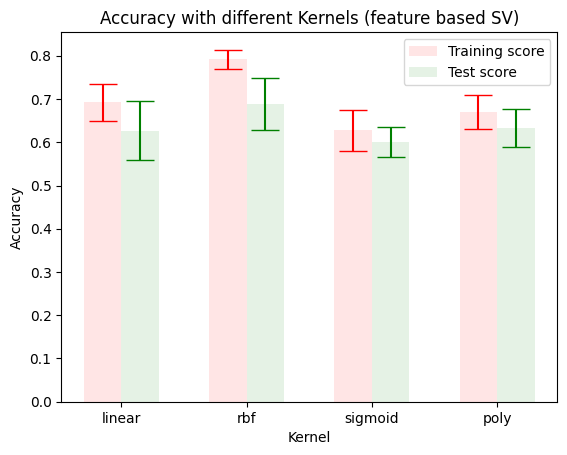

In [ ]:
# different kernels

kernels = ['linear', 'rbf', 'sigmoid', 'poly']
all_train = []
all_test = []

for train_index, test_index in sss10.split(data_train_features_sv, labels_train):
    train_scores = []
    test_scores = []
    
    split_X_train = data_train_features_sv[train_index]
    split_y_train = labels_train[train_index]
    split_X_test = data_train_features_sv[test_index]
    split_y_test = labels_train[test_index]

    for kernel in kernels:
        clf = skl.svm.SVC(kernel=kernel, degree=1)
        clf.fit(split_X_train, split_y_train)

        # Test the classifier on the training data and plot
        score_train = clf.score(split_X_train, split_y_train)
        score_test = clf.score(split_X_test, split_y_test)

        train_scores.append(score_train)
        test_scores.append(score_test)
        
    all_train.append(train_scores)
    all_test.append(test_scores)

# Create numpy array of scores and calculate the mean and std
all_train = np.array(all_train)
all_test = np.array(all_test)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)

# Plot the mean scores and the std as shading
br1 = np.arange(len(kernels))
br2 = [x + 0.3 for x in br1]

fig = plt.figure()
plt.bar(br1, train_scores_mean, color = 'r', alpha = 0.1, width = 0.3, label="Training score", yerr=train_scores_std, ecolor='r', capsize=10)
plt.bar(br2, test_scores_mean, color = 'g', alpha = 0.1, width = 0.3, label="Test score", yerr=test_scores_std, ecolor='g', capsize=10)
plt.xticks([r + 0.15 for r in range(len(kernels))], kernels)
plt.legend()
plt.title('Accuracy with different Kernels (feature based SV)')
plt.xlabel('Kernel')
plt.ylabel('Accuracy')

### ROC curve

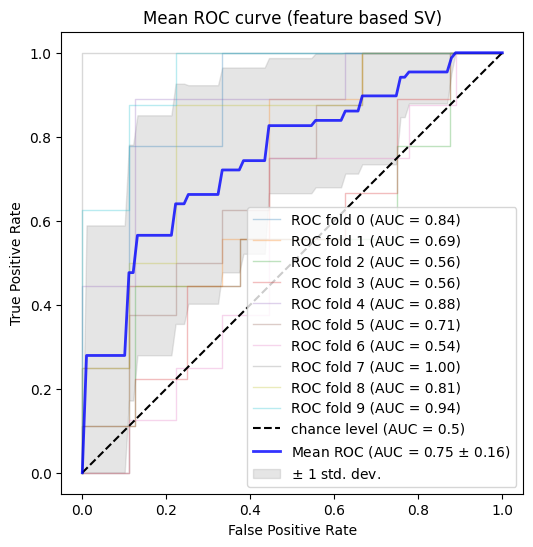

Mean accuracy: 0.68 (std: 0.14)


In [ ]:
# ROC features (rbf kernel)

svc = skl.svm.SVC(kernel = 'rbf')
cv = skl.model_selection.StratifiedKFold(n_splits=10)

tprs = []
aucs = []
accuracy = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(data_train_features_sv, labels_train)):
    svc.fit(data_train_features_sv[train], labels_train[train])
    viz = skl.metrics.RocCurveDisplay.from_estimator(
        svc,
        data_train_features_sv[test],
        labels_train[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    y_pred = svc.predict(data_train_features_sv[test])
    accuracy.append(skl.metrics.accuracy_score(labels_train[test], y_pred))

ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = skl.metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Mean ROC curve (feature based SV)",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()

mean_accuracy = np.mean(accuracy)
std_accuracy = np.std(accuracy)
print(f'Mean accuracy: {np.round(mean_accuracy, decimals=2)} (std: {np.round(std_accuracy, decimals=2)})')

### Learning curve

Text(0.5, 1.0, 'Learning curve feature based Support Vector Classifier')

<Figure size 640x480 with 0 Axes>

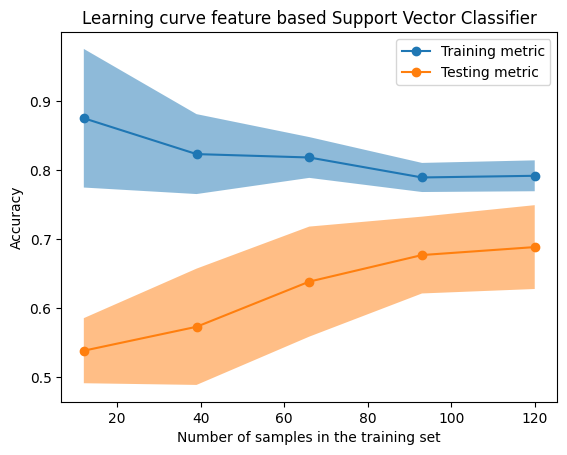

In [ ]:
# learning curve
clf = skl.svm.SVC(kernel = 'rbf')

fig = plt.figure()

common_params = {
    "X": data_train_features_sv,
    "y": labels_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": sss10,
    "score_type": "both",
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

skl.model_selection.LearningCurveDisplay.from_estimator(clf, **common_params)
plt.title('Learning curve feature based Support Vector Classifier')

# Random Forest classifier

## RF classification with components

### Number of trees

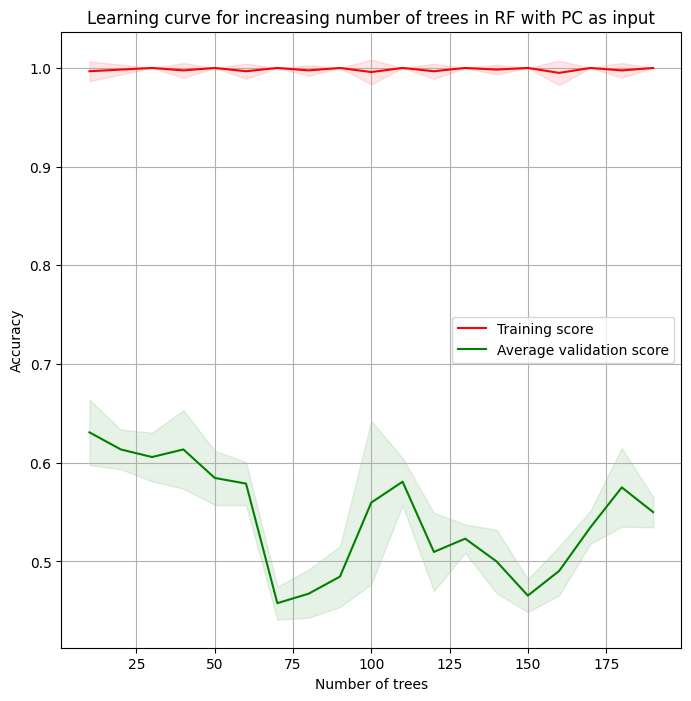

In [ ]:
# number of trees

#Perform random forest classification with principal components as input in 10 folds with 10-200 trees
num_trees = range(10, 200, 10)

# Create empty lists to store the training and validation scores
train_scores_pca = []
val_scores_pca = []

for i, (train, test) in enumerate(sss10.split(data_train_pca, labels_train)):
    train_data = data_train_pca[train]
    train_labels = labels_train[train]
    val_data = data_train_pca[test]
    val_labels = labels_train[test]

# Loop through each value of the number of trees and fit a random forest classifier
    for n in num_trees:
        clf = skl.ensemble.RandomForestClassifier(n_estimators=n, random_state=10007)
        clf.fit(train_data, train_labels)
    # Calculate the training and validation scores
        train_pred = clf.predict(train_data)
        val_pred = clf.predict(val_data)
        train_scores_pca.append(skl.metrics.accuracy_score(train_labels, train_pred))
        val_scores_pca.append(skl.metrics.accuracy_score(val_labels, val_pred))

# Plot the learning curve
train_grouped_pca = np.array(train_scores_pca)
train_grouped_pca = train_grouped_pca.reshape((-1, 10))
train_mean_pca = np.mean(train_grouped_pca, axis=1)
train_std_pca = train_grouped_pca.std(axis=1)

val_grouped_pca = np.array(val_scores_pca)
val_grouped_pca = val_grouped_pca.reshape((-1, 10))
val_mean_pca = np.mean(val_grouped_pca, axis=1)
val_std_pca = val_grouped_pca.std(axis=1)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.grid()
ax.fill_between(num_trees, train_mean_pca - train_std_pca,
                     train_mean_pca + train_std_pca, alpha=0.1,
                     color="r")
ax.fill_between(num_trees, val_mean_pca - val_std_pca,
                     val_mean_pca + val_std_pca, alpha=0.1,
                     color="g")
ax.plot(num_trees, train_mean_pca, label='Training score', color="r")
ax.plot(num_trees, val_mean_pca, label='Average validation score', color="g")
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.title('Learning curve for increasing number of trees in RF with PC as input')
plt.legend()
plt.show()

### ROC curve

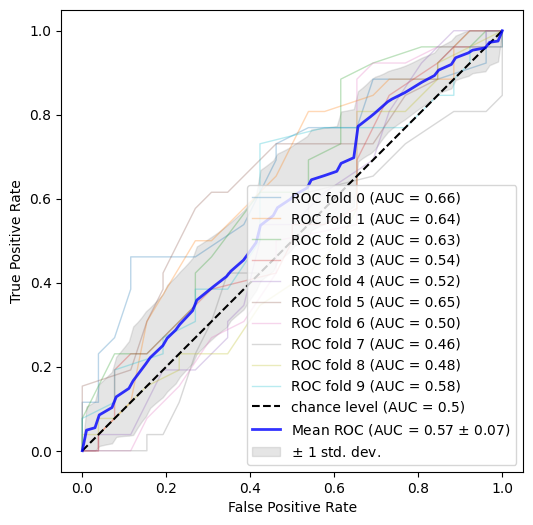

Mean accuracy: 0.56 (std: 0.07)


In [ ]:
# ROC curve (40 trees)

tprs = []
aucs = []
accuracy = []
mean_fpr = np.linspace(0, 1, 100)
rfc = skl.ensemble.RandomForestClassifier(n_estimators= 40, random_state=10007)
fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(sss10.split(data_train_pca, labels_train)):
    train_data_pca = data_train_pca[train]
    train_labels = labels_train[train]
    val_data_pca = data_train_pca[test]
    val_labels = labels_train[test]

    rfc.fit(train_data_pca, train_labels)    
    viz = skl.metrics.RocCurveDisplay.from_estimator(rfc, val_data_pca, val_labels, name=f"ROC fold {fold}", alpha=0.3, lw=1, ax=ax,)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    y_pred = rfc.predict(data_train_pca[test])
    accuracy.append(skl.metrics.accuracy_score(labels_train[test], y_pred))

ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = skl.metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    # title=f"Mean ROC curve with variability\n(Positive label '{fold+1}')",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()

mean_accuracy = np.mean(accuracy)
std_accuracy = np.std(accuracy)
print(f'Mean accuracy: {np.round(mean_accuracy, decimals=2)} (std: {np.round(std_accuracy, decimals=2)})')

### Learning curve

Text(0.5, 1.0, 'Learning curve Random Forest with PCA')

<Figure size 640x480 with 0 Axes>

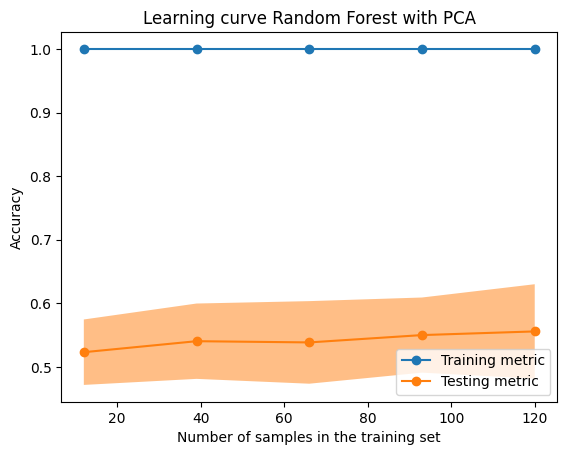

In [ ]:
# learning curve
clf = skl.ensemble.RandomForestClassifier(n_estimators= 40, random_state=10007)

fig = plt.figure()

common_params = {
    "X": data_train_pca,
    "y": labels_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": sss10,
    "score_type": "both",
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

skl.model_selection.LearningCurveDisplay.from_estimator(clf, **common_params)
plt.title('Learning curve Random Forest with PCA')

## RF classification with features

### Number of trees

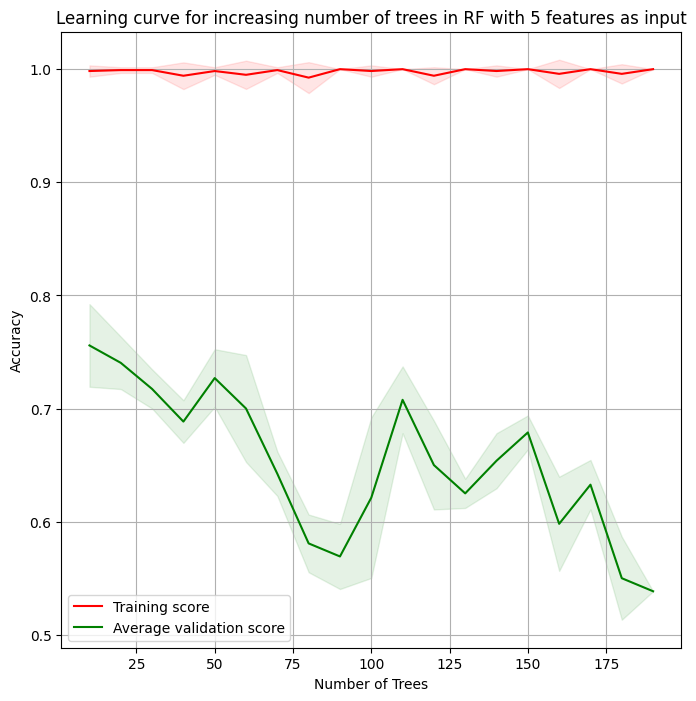

In [ ]:
# Number of trees

num_trees = range(10, 200, 10)

# Create empty lists to store the training and validation scores
train_scores_feat = []
val_scores_feat = []

for i, (train, test) in enumerate(sss10.split(data_train_features_rf, labels_train)):
    train_data = data_train_features_rf[train]
    train_labels = labels_train[train]
    val_data = data_train_features_rf[test]
    val_labels = labels_train[test]

# Loop through each value of the number of trees and fit a random forest classifier
    for n in num_trees:
        clf = skl.ensemble.RandomForestClassifier(n_estimators=n, random_state=10007)
        clf.fit(train_data, train_labels)
        # Calculate the training and validation scores
        train_pred = clf.predict(train_data)
        val_pred = clf.predict(val_data)
        train_scores_feat.append(skl.metrics.accuracy_score(train_labels, train_pred))
        val_scores_feat.append(skl.metrics.accuracy_score(val_labels, val_pred))

# Plot the learning curve
train_grouped_feat = np.array(train_scores_feat)
train_grouped_feat = train_grouped_feat.reshape((-1, 10))
train_mean_feat = np.mean(train_grouped_feat, axis=1)
train_std_feat = train_grouped_feat.std(axis=1)

val_grouped_feat = np.array(val_scores_feat)
val_grouped_feat = val_grouped_feat.reshape((-1, 10))
val_mean_feat = np.mean(val_grouped_feat, axis=1)
val_std_feat = val_grouped_feat.std(axis=1)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.grid()
ax.fill_between(num_trees, train_mean_feat - train_std_feat,
                     train_mean_feat + train_std_feat, alpha=0.1,
                     color="r")
ax.fill_between(num_trees, val_mean_feat - val_std_feat,
                     val_mean_feat + val_std_feat, alpha=0.1,
                     color="g")
ax.plot(num_trees, train_mean_feat, label='Training score', color="r")
ax.plot(num_trees, val_mean_feat, label='Average validation score', color="g")
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Learning curve for increasing number of trees in RF with 5 features as input')
plt.legend()
plt.show()

### ROC curve

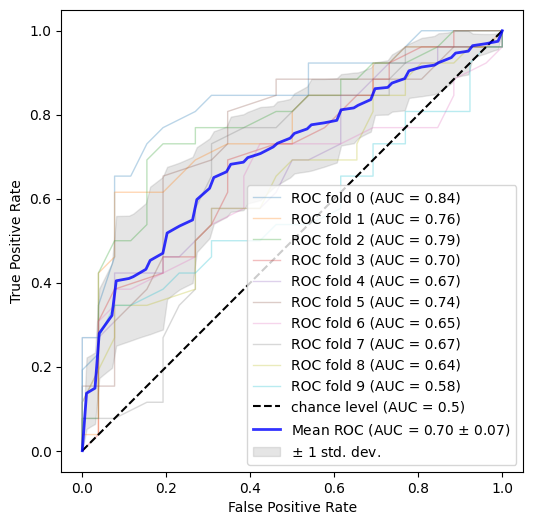

Mean accuracy: 0.67 (std: 0.08)


In [ ]:
# ROC curve (50 trees)

tprs_feat = []
aucs_feat = []
accuracy = []
mean_fpr_feat = np.linspace(0, 1, 100)

rfc = skl.ensemble.RandomForestClassifier(n_estimators=50, random_state=10007)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(sss10.split(data_train_features_rf, labels_train)):
    train_data_feat = data_train_features_rf[train]
    train_labels = labels_train[train]
    val_data_feat = data_train_features_rf[test]
    val_labels = labels_train[test]

    rfc.fit(train_data_feat, train_labels)    
    viz = skl.metrics.RocCurveDisplay.from_estimator(rfc, val_data_feat, val_labels, name=f"ROC fold {fold}", alpha=0.3, lw=1, ax=ax,)
    interp_tpr = np.interp(mean_fpr_feat, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs_feat.append(interp_tpr)
    aucs_feat.append(viz.roc_auc)

    y_pred = rfc.predict(data_train_features_rf[test])
    accuracy.append(skl.metrics.accuracy_score(labels_train[test], y_pred))

ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr_feat = np.mean(tprs_feat, axis=0)
mean_tpr_feat[-1] = 1.0
mean_auc_feat = skl.metrics.auc(mean_fpr_feat, mean_tpr_feat)
std_auc_feat = np.std(aucs_feat)
ax.plot(
    mean_fpr_feat,
    mean_tpr_feat,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc_feat, std_auc_feat),
    lw=2,
    alpha=0.8,
)

std_tpr_feat = np.std(tprs_feat, axis=0)
tprs_upper_feat = np.minimum(mean_tpr_feat + std_tpr_feat, 1)
tprs_lower_feat = np.maximum(mean_tpr_feat - std_tpr_feat, 0)
ax.fill_between(
    mean_fpr_feat,
    tprs_lower_feat,
    tprs_upper_feat,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    # title=f"Mean ROC curve with variability\n(Positive label '{fold+1}')",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()

mean_accuracy = np.mean(accuracy)
std_accuracy = np.std(accuracy)
print(f'Mean accuracy: {np.round(mean_accuracy, decimals=2)} (std: {np.round(std_accuracy, decimals=2)})')

### Learning curve

Text(0.5, 1.0, 'Learning curve Random Forest with input features')

<Figure size 640x480 with 0 Axes>

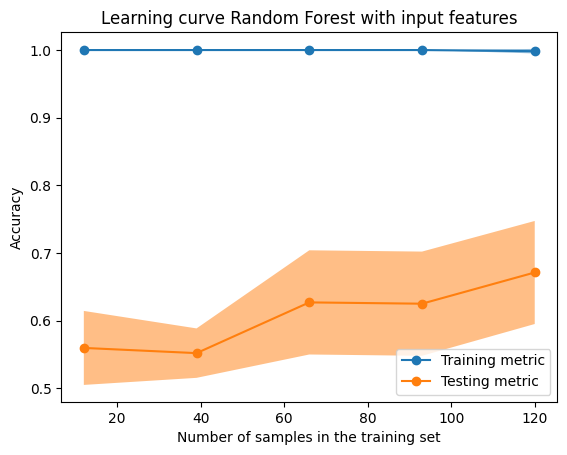

In [ ]:
# Learning curve

clf = skl.ensemble.RandomForestClassifier(n_estimators=50, random_state=10007)

fig = plt.figure()

common_params = {
    "X": data_train_features_rf,
    "y": labels_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": sss10,
    "score_type": "both",
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

skl.model_selection.LearningCurveDisplay.from_estimator(clf, **common_params)
plt.title('Learning curve Random Forest with input features')

# kNN classifier

## kNN classification with components

### Number of neighbors

Text(0, 0.5, 'Accuracy')

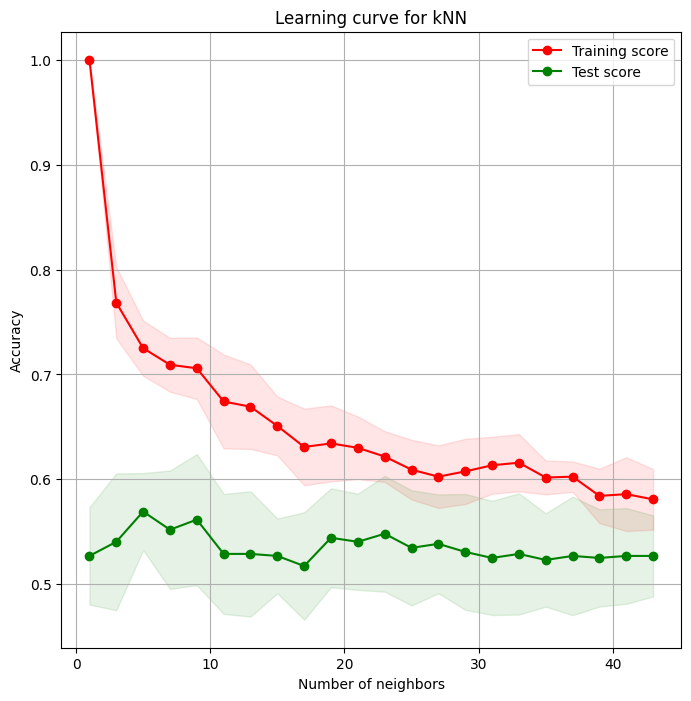

In [ ]:
# Test with different amounts of neighbors

k_list = list(range(1, 45, 2))
all_train = []
all_test = []


for train_index, test_index in sss10.split(data_train_pca, labels_train):
    train_scores = []
    test_scores = []
    
    split_X_train = data_train_pca[train_index]
    split_y_train = labels_train[train_index]
    split_X_test = data_train_pca[test_index]
    split_y_test = labels_train[test_index]

    for k in k_list:
        clf_knn = skl.neighbors.KNeighborsClassifier(n_neighbors=k)
        clf_knn.fit(split_X_train, split_y_train)

        # Test the classifier on the training data and plot
        score_train = clf_knn.score(split_X_train, split_y_train)
        score_test = clf_knn.score(split_X_test, split_y_test)

        train_scores.append(score_train)
        test_scores.append(score_test)
        
    all_train.append(train_scores)
    all_test.append(test_scores)
    

# Create numpy array of scores and calculate the mean and std
all_train = np.array(all_train)
all_test = np.array(all_test)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)

# Plot the mean scores and the std as shading
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.grid()
ax.fill_between(k_list, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(k_list, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
ax.plot(k_list, train_scores_mean, 'o-', color="r", label="Training score")
ax.plot(k_list, test_scores_mean, 'o-', color="g", label="Test score")

plt.legend()
plt.title('Learning curve for kNN')
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')

### ROC curve

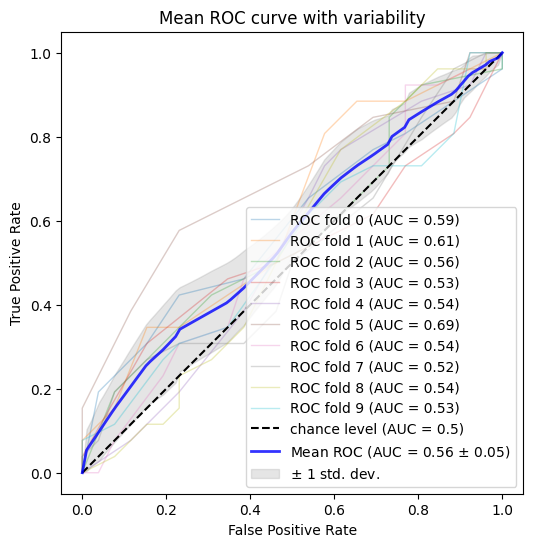

Mean accuracy: 0.53 (std: 0.05)


In [ ]:
# Receiver Operating Curve (with n_neighbors = 25)

cv = sss10
knn = skl.neighbors.KNeighborsClassifier(n_neighbors=25)

tprs = []
aucs = []
accuracy = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(data_train_pca, labels_train)):
    knn.fit(data_train_pca[train], labels_train[train])
    viz = skl.metrics.RocCurveDisplay.from_estimator(
        knn,
        data_train_pca[test],
        labels_train[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    y_pred = knn.predict(data_train_pca[test])
    accuracy.append(skl.metrics.accuracy_score(labels_train[test], y_pred))

ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = skl.metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()

mean_accuracy = np.mean(accuracy)
std_accuracy = np.std(accuracy)
print(f'Mean accuracy: {np.round(mean_accuracy, decimals=2)} (std: {np.round(std_accuracy, decimals=2)})')

### Learning curve

<Figure size 640x480 with 0 Axes>

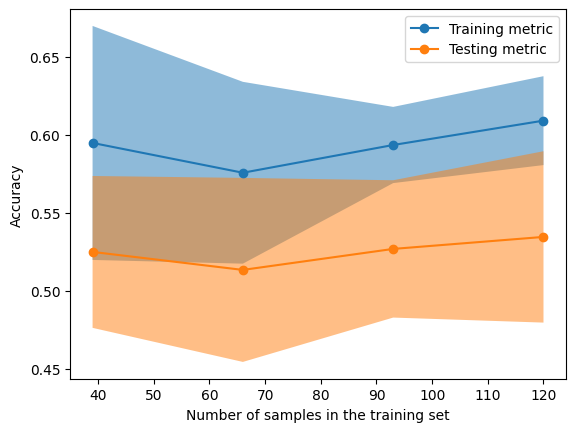

In [ ]:
# Learning curve

knn = skl.neighbors.KNeighborsClassifier(n_neighbors=25)

fig = plt.figure()

common_params = {
    "X": data_train_pca,
    "y": labels_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": sss10,
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

skl.model_selection.LearningCurveDisplay.from_estimator(knn, **common_params)

## kNN classification with features

### Number of neighbors

Text(0, 0.5, 'Accuracy')

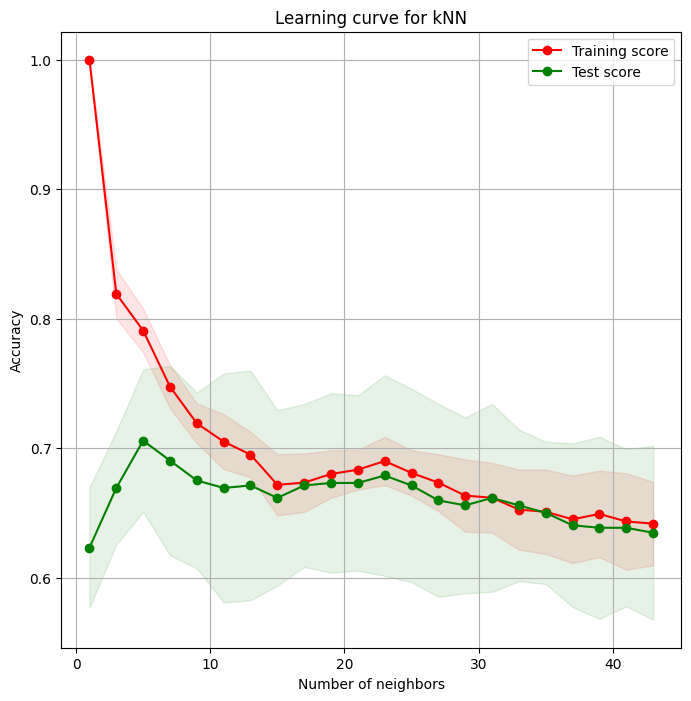

In [ ]:
# Test with different amounts of neighbors
k_list = list(range(1, 45, 2))
all_train = []
all_test = []

for train_index, test_index in sss10.split(data_train_features_knn, labels_train):
    train_scores = []
    test_scores = []
    
    split_X_train = data_train_features_knn[train_index]
    split_y_train = labels_train[train_index]
    split_X_test = data_train_features_knn[test_index]
    split_y_test = labels_train[test_index]

    for k in k_list:
        clf_knn = skl.neighbors.KNeighborsClassifier(n_neighbors=k)
        clf_knn.fit(split_X_train, split_y_train)

        # Test the classifier on the training data and plot
        score_train = clf_knn.score(split_X_train, split_y_train)
        score_test = clf_knn.score(split_X_test, split_y_test)

        train_scores.append(score_train)
        test_scores.append(score_test)
        
    all_train.append(train_scores)
    all_test.append(test_scores)
    

# Create numpy array of scores and calculate the mean and std
all_train = np.array(all_train)
all_test = np.array(all_test)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)

# Plot the mean scores and the std as shading
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.grid()
ax.fill_between(k_list, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(k_list, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
ax.plot(k_list, train_scores_mean, 'o-', color="r", label="Training score")
ax.plot(k_list, test_scores_mean, 'o-', color="g", label="Test score")

plt.legend()
plt.title('Learning curve for kNN')
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')

### ROC curve

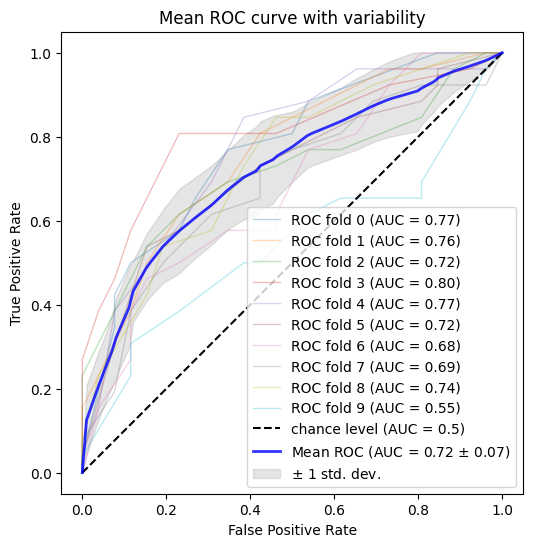

Mean accuracy: 0.66 (std: 0.07)


In [ ]:
# Receiver Operating Curve (with n_neighbors = 15)

cv = sss10
knn = skl.neighbors.KNeighborsClassifier(n_neighbors=15)

tprs = []
aucs = []
accuracy = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(data_train_features_knn, labels_train)):
    knn.fit(data_train_features_knn[train], labels_train[train])
    viz = skl.metrics.RocCurveDisplay.from_estimator(
        knn,
        data_train_features_knn[test],
        labels_train[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    y_pred = knn.predict(data_train_features_knn[test])
    accuracy.append(skl.metrics.accuracy_score(labels_train[test], y_pred))

ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = skl.metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()

mean_accuracy = np.mean(accuracy)
std_accuracy = np.std(accuracy)
print(f'Mean accuracy: {np.round(mean_accuracy, decimals=2)} (std: {np.round(std_accuracy, decimals=2)})')

### Learning curve

<Figure size 640x480 with 0 Axes>

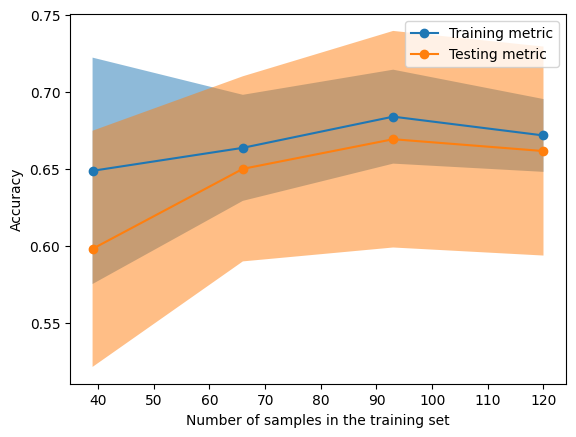

In [ ]:
# Learning curve
knn = skl.neighbors.KNeighborsClassifier(n_neighbors=15)

fig = plt.figure()

common_params = {
    "X": data_train_features_knn,
    "y": labels_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": sss10,
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

skl.model_selection.LearningCurveDisplay.from_estimator(knn, **common_params)


# Final experiment

## SV

In [ ]:
data_train_sv = data_train[features_sv]
data_test_sv = data_test[features_sv]

svc = skl.svm.SVC(kernel = 'rbf')
svc.fit(data_train_sv, labels_train)

labels_test_pred = svc.predict(data_test_sv)
accuracy_sv = skl.metrics.accuracy_score(labels_test, labels_test_pred)
print(f'Accuracy: {accuracy_sv}')

cm_svm = confusion_matrix(labels_test, labels_test_pred)
print(f'Confusion matrix: {cm_svm}')

report_sv = skl.metrics.classification_report(labels_test, labels_test_pred)
print(report_sv)

Accuracy: 0.6486486486486487
Confusion matrix: [[22 16]
 [10 26]]
              precision    recall  f1-score   support

        GIST       0.69      0.58      0.63        38
    non-GIST       0.62      0.72      0.67        36

    accuracy                           0.65        74
   macro avg       0.65      0.65      0.65        74
weighted avg       0.65      0.65      0.65        74



## RF

In [ ]:
data_train_rf = data_train[features_rf]
data_test_rf = data_test[features_rf]

rfc = skl.ensemble.RandomForestClassifier(n_estimators=50, random_state=10007)
rfc.fit(data_train_rf, labels_train)

labels_test_pred = rfc.predict(data_test_rf)
accuracy_rf = skl.metrics.accuracy_score(labels_test, labels_test_pred)
print(f'Accuracy: {accuracy_rf}')

cm_rf = confusion_matrix(labels_test, labels_test_pred)
print(f'Confusion matrix: {cm_rf}')

report_rf = skl.metrics.classification_report(labels_test, labels_test_pred)
print(report_rf)

Accuracy: 0.6486486486486487
Confusion matrix: [[25 13]
 [13 23]]
              precision    recall  f1-score   support

        GIST       0.66      0.66      0.66        38
    non-GIST       0.64      0.64      0.64        36

    accuracy                           0.65        74
   macro avg       0.65      0.65      0.65        74
weighted avg       0.65      0.65      0.65        74



## kNN

In [ ]:
data_train_knn = data_train[features_knn]
data_test_knn = data_test[features_knn]

knn = skl.neighbors.KNeighborsClassifier(n_neighbors=15)
knn.fit(data_train_knn, labels_train)

labels_test_pred = knn.predict(data_test_knn)
accuracy_knn = skl.metrics.accuracy_score(labels_test, labels_test_pred)
print(f'Accuracy: {accuracy_knn}')

cm_knn = confusion_matrix(labels_test, labels_test_pred)
print(f'Confusion matrix: {cm_knn}')

report_knn = skl.metrics.classification_report(labels_test, labels_test_pred)
print(report_knn)

Accuracy: 0.5945945945945946
Confusion matrix: [[20 18]
 [12 24]]
              precision    recall  f1-score   support

        GIST       0.62      0.53      0.57        38
    non-GIST       0.57      0.67      0.62        36

    accuracy                           0.59        74
   macro avg       0.60      0.60      0.59        74
weighted avg       0.60      0.59      0.59        74



## ROC curves

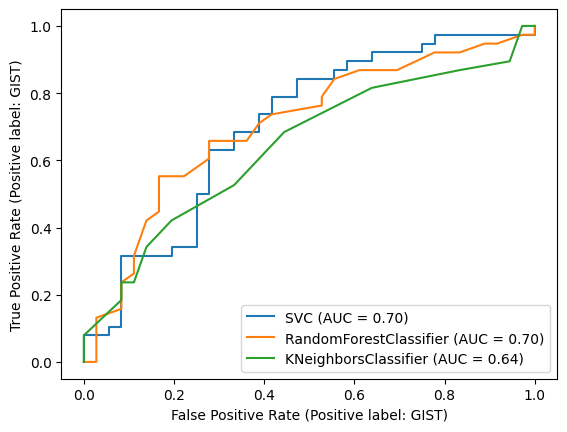

In [ ]:
# ROC curves
fig, ax = plt.subplots(1,1)
skl.metrics.RocCurveDisplay.from_estimator(svc, data_test_sv, labels_test, ax=ax, pos_label='GIST')
skl.metrics.RocCurveDisplay.from_estimator(rfc, data_test_rf, labels_test, ax=ax, pos_label='GIST')
skl.metrics.RocCurveDisplay.from_estimator(knn, data_test_knn, labels_test, ax=ax, pos_label='GIST')
plt.show()